[[ 24.94003847  12.73268299  -1.38095598 ... -64.02389647 -67.76356741
  -61.18058974]
 [-18.55666362 -42.51586944 -60.80795253 ... -26.39439597   6.86544434
   41.4436393 ]
 [-16.04755868 -22.03971648 -23.23089505 ... -25.03391682 -29.2936105
  -31.3712619 ]
 ...
 [ 24.73021466  34.94179045  38.82924248 ...   4.99619196  -9.93322885
  -25.6299042 ]
 [ 25.33720124  43.00958768  51.93221654 ... -30.76392977 -58.45411318
  -74.0191717 ]
 [ -6.4753501   15.86720969  37.73898369 ...  37.9440317    8.26766066
  -26.92595056]]


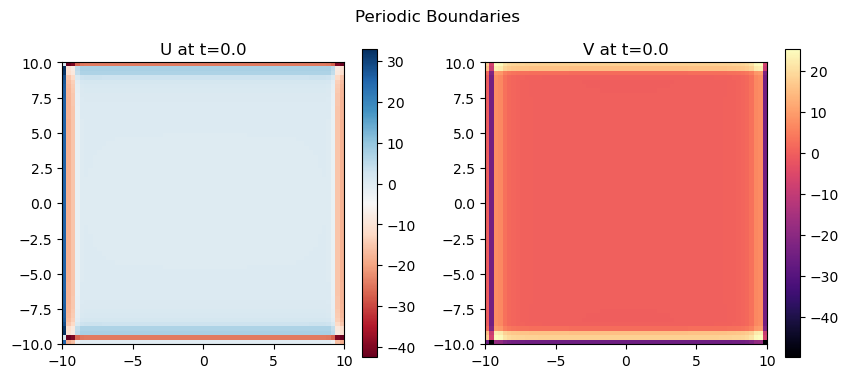

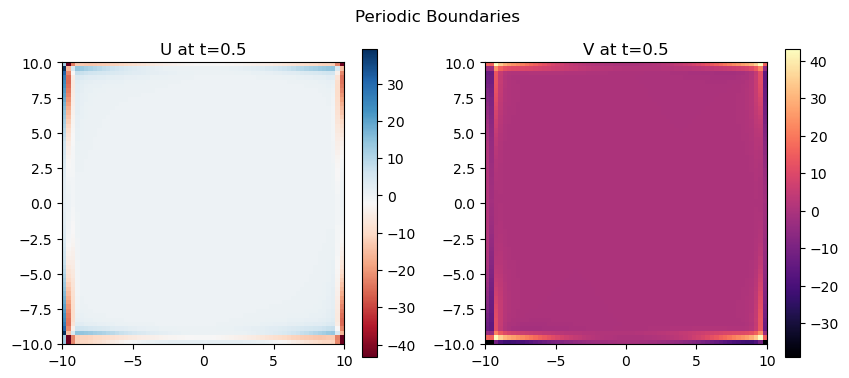

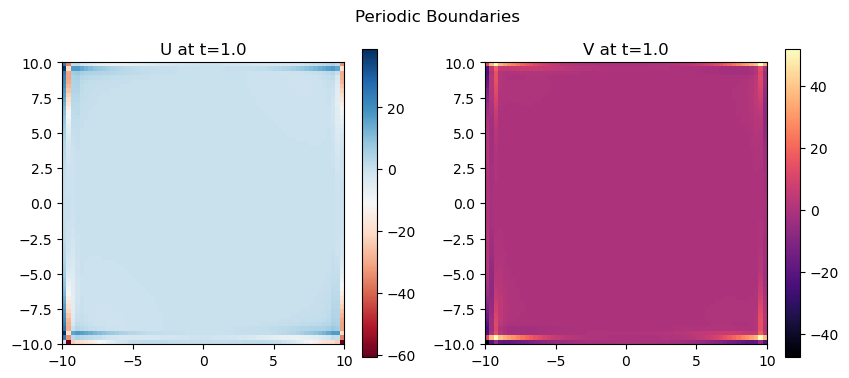

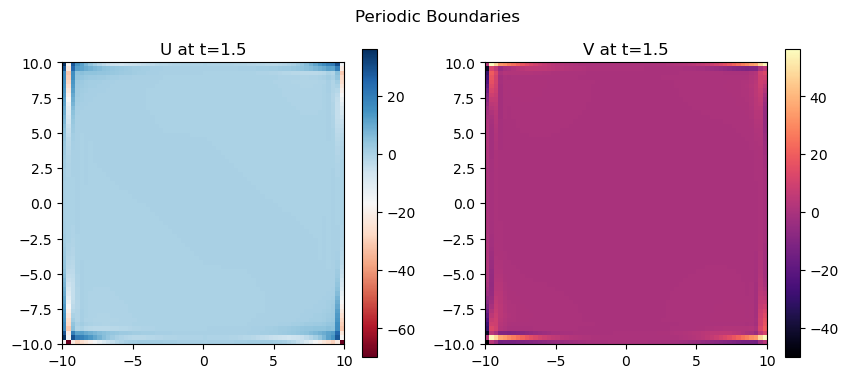

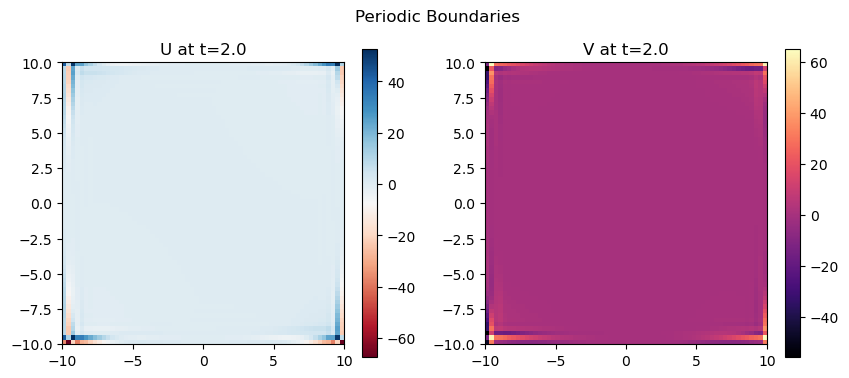

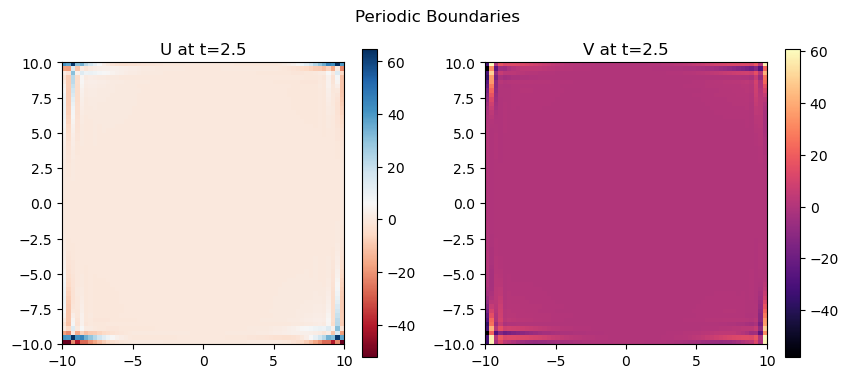

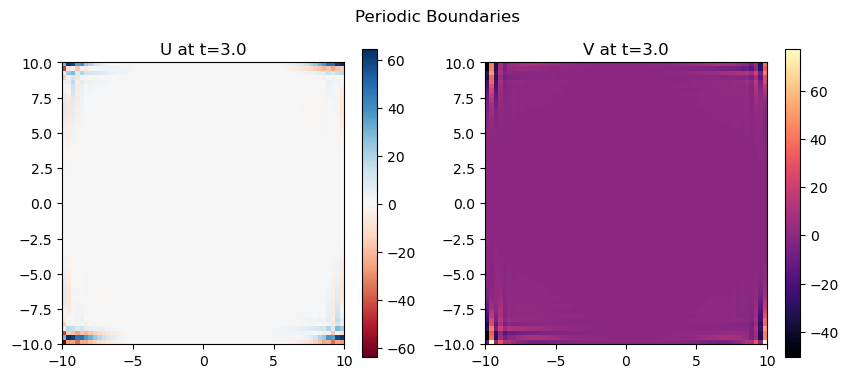

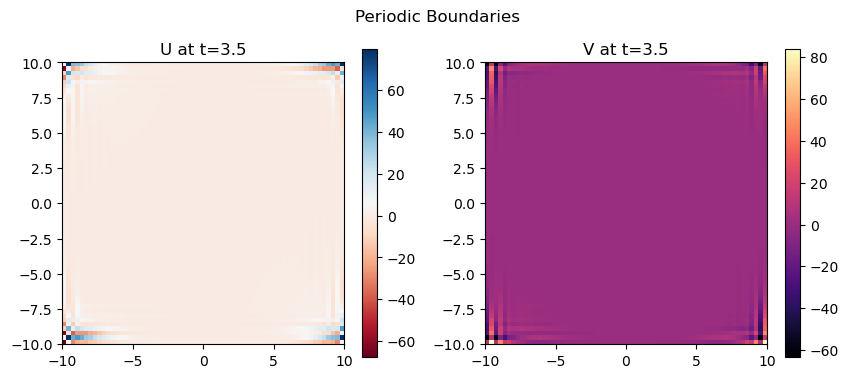

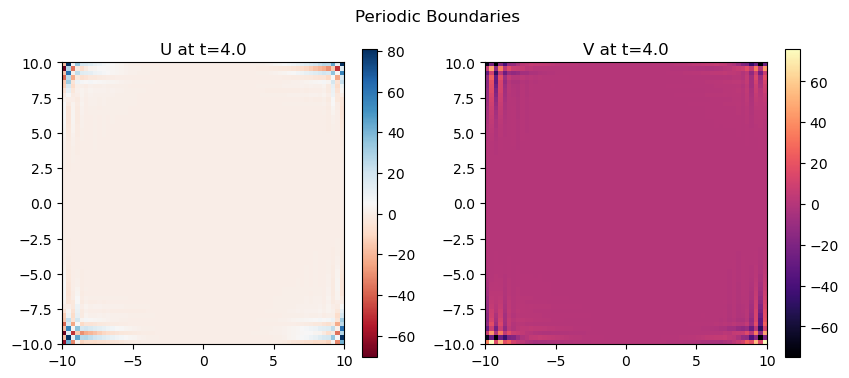

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
from scipy.integrate import solve_ivp

# Define parameters
D1 = D2 = 0.1                      # diffusion
beta = 1                           # for Gibbs phenomenon
m = 1                              # number of spirals : want 1-2
tspan = np.arange(0, 4.5, 0.5)     # time 0-4s
Lx, Ly = 20, 20                    # x and y domain: [-10,10]
nx, ny = 64, 64                            # n = 64 pts
n = 64
N = n ** 2                         # 64 x 64 grid

# Define spatial domain and initial conditions
x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)

# Define tanh lol
def tanh(x):
    return np.sinh(x) / np.cosh(x)

A = np.sqrt(X**2 + Y**2)
theta = np.angle(X + 1j * Y)
U0 = tanh(A) * np.cos(m * theta - A)
V0 = tanh(A) * np.sin(m * theta - A)
U1 = fft2(U0)
V1 = fft2(V0)
# Stack U and V for integration
UV_stack = np.concatenate([U0.flatten(), V0.flatten()])
UV_stack_fft = np.concatenate([U1.flatten(), V1.flatten()])

# Define RHS
def reaction_diffusion_fft(t, UV, n, L, D1, D2, beta, periodic=True):
    if periodic:
        # Unstack U_hat and V_hat
        U_hat = UV[:n**2].reshape((n, n))
        V_hat = UV[n**2:].reshape((n, n))
    
        # Compute wavenumbers
        k = 2 * np.pi * np.fft.fftfreq(n, d=L / n)  # Wavenumbers in 1D
        kx, ky = np.meshgrid(k, k)  # Create 2D wavenumber grid
        k_squared = kx**2 + ky**2
    
        # Transform back to real space to compute non-linear terms
        U_real = np.real(ifft2(U_hat))
        V_real = np.real(ifft2(V_hat))
    
        # Compute A^2, lambda(A), and omega(A)
        A2 = U_real**2 + V_real**2
        lam = 1 - A2
        omega = -beta * A2
    
        # Reaction terms in real space
        Ut_real = lam * U_real - omega * V_real
        Vt_real = omega * U_real + lam * V_real
    
        # Transform reaction terms back to Fourier space
        Ut_hat = fft2(Ut_real)
        Vt_hat = fft2(Vt_real)
    
        # Add diffusion terms in Fourier space
        Ut_hat -= D1 * k_squared * U_hat
        Vt_hat -= D2 * k_squared * V_hat


    # Stack and return derivatives in Fourier space
    return np.concatenate([Ut_hat.flatten(), Vt_hat.flatten()])

# Solve the system for periodic boundaries
solution_periodic = solve_ivp(
    reaction_diffusion_fft, [tspan[0], tspan[-1]], UV_stack_fft, t_eval=tspan, args=(n, Lx, D1, D2, beta, True), method="RK45"
)

A1 = np.real(solution_periodic.y)
print(A1)

# Function to plot results
def plot_solution(solution, t_eval, n, L, title):
    for i, t in enumerate(t_eval):
        U = solution.y[:n**2, i].real.reshape((n, n))
        V = solution.y[n**2:, i].real.reshape((n, n))

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.title(f"U at t={t}")
        plt.imshow(U, extent=[-L/2, L/2, -L/2, L/2], origin='lower', cmap='RdBu')
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.title(f"V at t={t}")
        plt.imshow(V, extent=[-L/2, L/2, -L/2, L/2], origin='lower', cmap='magma')
        plt.colorbar()

        plt.suptitle(title)
        plt.show()

# Plot periodic boundaries
plot_solution(solution_periodic, tspan, n, Lx, "Periodic Boundaries")



In [67]:
from scipy.linalg import kron

# Define Chebyshev
def cheb(N):
    if N == 0:
        D = np.array([[0.]])
        x = np.array([1.])
    else:
        n = np.arange(0, N + 1)
        x = np.cos(np.pi * n / N).reshape(N + 1, 1)
        c = (np.hstack(([2.], np.ones(N - 1), [2.])) * (-1)**n).reshape(N + 1, 1)
        X = np.tile(x, (1, N + 1))
        dX = X - X.T
        D = (c @ (1. / c.T)) / (dX + np.eye(N + 1))
        D -= np.diag(np.sum(D.T, axis=0))
    return D, x.flatten()

# Parameters
D1 = D2 = 0.1                      # diffusion
beta = 1                           # for Gibbs phenomenon
m = 1                              # number of spirals : want 1-2
tspan = np.arange(0, 4.5, 0.5)     # time 0-4s
Lx, Ly = 20, 20                    # x and y domain: [-10,10]
N = 30
D, x = cheb(N)
D[N, :] = 0
D[0, :] = 0
Dxx = np.dot(D, D)/(Lx/2)**2
y = x
N2 = (N+1)*(N+1)
I = np.eye(len(Dxx))  # Identity matrix
L = kron(I, Dxx) + kron(Dxx, I)  # 2D Laplacian

X, Y = np.meshgrid(x, y)
# Rescale the grid
X = X * Lx / 2
Y = Y * Ly / 2

A = np.sqrt(X**2 + Y**2)
theta = np.angle(X + 1j * Y)
U0 = tanh(A) * np.cos(m * theta - A)
V0 = tanh(A) * np.sin(m * theta - A)
# Stack U and V for integration
UV_stack = np.hstack([U0.flatten(), V0.flatten()])

def reaction_diffusion_cheb(t, UV, n, L, D1, D2, beta, periodic=True):
    # Unstack U_hat and V_hat
    U_hat = UV[:N2]
    V_hat = UV[N2:]


    # Compute A^2, lambda(A), and omega(A)
    A2 = U_hat**2 + V_hat**2
    lam = 1 - A2
    omega = -beta * A2
    
    Ut_hat = lam * U_hat - omega * V_hat
    Vt_hat = omega * U_hat + lam * V_hat
    
    # cheb laplacian
    rhs_u = D1 * np.dot(L, U_hat) + Ut_hat
    rhs_v = D2 * np.dot(L, V_hat) + Vt_hat

    rhs = np.hstack([rhs_u, rhs_v])

    return rhs



# # Solve the system for no-flux boundaries
solution_no_flux = solve_ivp(
    reaction_diffusion_cheb, [tspan[0], tspan[-1]], UV_stack, t_eval=tspan, args=(N2, Lx, D1, D2, beta, False), method="RK45"
)

print(solution_no_flux.y)
print(solution_no_flux.y.shape)

[[ 0.70358468 -0.35656379 -1.71967676 ... -1.70015229 -0.45637364
   1.63364247]
 [ 0.73241275 -0.2894343  -1.72535699 ... -1.68484948 -0.52519267
   1.60833383]
 [ 0.81058026 -0.08718859 -1.72473123 ... -1.62233443 -0.72419649
   1.51688653]
 ...
 [ 0.58562756  1.65003888  0.11153889 ...  0.60850128 -1.57359729
  -0.83726951]
 [ 0.6808609   1.62679376 -0.10140013 ...  0.40438229 -1.65070943
  -0.64438129]
 [ 0.71061143  1.61341018 -0.17277322 ...  0.33425293 -1.67104521
  -0.57721508]]
(1922, 9)
